# Ejercicio 4: Modelo Probabilístico
### Josune Singaña
## Objetivo de la práctica
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

## Parte 0: Carga del Corpus

In [1]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroupsdocs = newsgroups.data

## Preprocesamiento

  Preprocesamiento completo:
1. Limpieza de HTML y caracteres especiales
2. Conversión a minúsculas
3. Tokenización
4. Eliminación de stopwords
5. Stemming

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Cargar stopwords
try:
    stop_words = set(stopwords.words('english'))
except:
    nltk.download('stopwords', quiet=True)
    stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()

def clean_text(doc):
    #Limpia HTML y caracteres especiales
    return re.sub(pattern=r'<.*?>', repl='', string=doc)\
             .replace('.', ' ').replace(',', '').replace('(', '')\
             .replace(')', '').replace('"', '').replace("'", '')\
             .replace('\x08', '')

def preprocess_text(text):
    # 1. Limpieza
    text = clean_text(text)
    
    # 2. Normalización (lowercase)
    text = text.lower()
    
    # 3. Tokenización
    tokens = text.split()
    
    # 4. Eliminación de stopwords
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # 5. Stemming
    tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(tokens)

## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad 
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

In [3]:
# Preprocesando documentos
df = pd.DataFrame(newsgroupsdocs, columns=['texto'])
df['prep'] = df['texto'].apply(preprocess_text)

#Calculando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df['prep'])

print(f"Matriz TF-IDF: {tfidf_matrix.shape}")
print(f"Vocabulario: {len(vectorizer.vocabulary_)} términos")


Matriz TF-IDF: (18846, 5000)
Vocabulario: 5000 términos


## Parte 2: Ranking de documentos usando TF-IDF

### Actividad 

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

In [6]:
# Definir consulta
query = "government"
print(f"\n=== CONSULTA: '{query}' ===")
# Preprocesar la consulta 
query_prep = preprocess_text(query)

# Transformar consulta al espacio TF-IDF
query_vec = vectorizer.transform([query_prep])

# Calcular similitud coseno
cosine_sim = cosine_similarity(query_vec, tfidf_matrix).flatten()

# Crear ranking
ranking_tfidf = pd.DataFrame({
    'Documento': range(len(df)),
    'Score_TFIDF': cosine_sim
}).sort_values(by='Score_TFIDF', ascending=False)

print("\n--- TOP 10 TF-IDF ---")
print(ranking_tfidf.head(10))


=== CONSULTA: 'government' ===

--- TOP 10 TF-IDF ---
       Documento  Score_TFIDF
5905        5905     0.517461
8841        8841     0.488046
16786      16786     0.474609
15813      15813     0.426868
1817        1817     0.410644
7051        7051     0.408604
5225        5225     0.408351
7270        7270     0.406763
17069      17069     0.404157
688          688     0.403103


## Parte 3: Ranking con BM25

### Actividad 

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

In [8]:
def bm25_score(query_terms, doc_tokens, df_dict, N, avgdl, k1=1.5, b=0.75):
    score = 0.0
    doc_len = len(doc_tokens)
    doc_term_freq = Counter(doc_tokens)
    
    for term in query_terms:
        if term not in df_dict:
            continue
            
        # Frecuencia del término en el documento
        tf = doc_term_freq.get(term, 0)
        
        # Document frequency
        df = df_dict[term]
        
        # IDF con corrección de 0.5 (fórmula BM25)
        idf = np.log((N - df + 0.5) / (df + 0.5))
        
        # Normalización por longitud
        norm = 1 - b + b * (doc_len / avgdl)
        
        # Score BM25 para este término
        term_score = idf * ((k1 + 1) * tf) / (k1 * norm + tf)
        score += term_score
    
    return score


def calcular_bm25_ranking(query, docs_prep, k1=1.5, b=0.75):

    # 1. Tokenizar documentos
    docs_tokens = [doc.split() for doc in docs_prep]
    
    # 2. Tokenizar query
    query_terms = query.split()
    
    # 3. Estadísticas del corpus
    N = len(docs_tokens)
    avgdl = np.mean([len(doc) for doc in docs_tokens])
    
    print(f"- Total documentos (N): {N}")
    print(f"- Longitud promedio (avgdl): {avgdl:.2f}")
    
    # 4. Calcular Document Frequency (DF)
    df_dict = {}
    for doc in docs_tokens:
        unique_terms = set(doc)
        for term in unique_terms:
            df_dict[term] = df_dict.get(term, 0) + 1
    
    print(f"- Términos únicos: {len(df_dict)}")
    
    # 5. Calcular score BM25 para cada documento
    scores = []
    for doc_tokens in docs_tokens:
        score = bm25_score(query_terms, doc_tokens, df_dict, N, avgdl, k1, b)
        scores.append(score)
    
    # 6. Crear ranking
    ranking = pd.DataFrame({
        'Documento': range(len(docs_tokens)),
        'Score_BM25': scores
    }).sort_values(by='Score_BM25', ascending=False)
    
    return ranking


# Calcular ranking BM25
ranking_bm25 = calcular_bm25_ranking(query_prep, df['prep'])

print("\n--- TOP 10 BM25 ---")
print(ranking_bm25.head(10))


- Total documentos (N): 18846
- Longitud promedio (avgdl): 97.67
- Términos únicos: 155371

--- TOP 10 BM25 ---
       Documento  Score_BM25
5905        5905    6.190869
395          395    6.000479
7270        7270    5.937984
14176      14176    5.929614
5225        5225    5.918625
17069      17069    5.885903
8841        8841    5.793975
6432        6432    5.724156
7051        7051    5.722015
8791        8791    5.717321


## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad 

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?


Documentos comunes en top 10: 6
IDs comunes: [5225, 5905, 7051, 7270, 8841, 17069]
Solo en TF-IDF: [688, 1817, 15813, 16786]
Solo en BM25: [395, 6432, 8791, 14176]


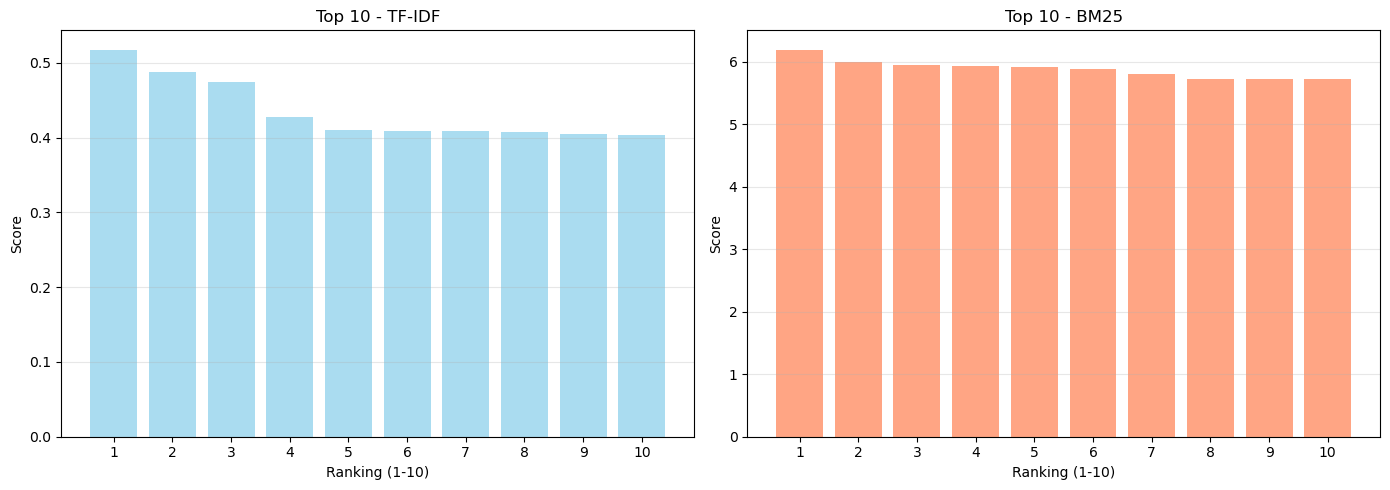

In [10]:
# Top 10 de cada modelo
top10_tfidf = ranking_tfidf.head(10)
top10_bm25 = ranking_bm25.head(10)

# Análisis de intersección
docs_tfidf = set(top10_tfidf['Documento'])
docs_bm25 = set(top10_bm25['Documento'])
docs_comunes = docs_tfidf & docs_bm25

print(f"\nDocumentos comunes en top 10: {len(docs_comunes)}")
print(f"IDs comunes: {sorted(docs_comunes)}")
print(f"Solo en TF-IDF: {sorted(docs_tfidf - docs_bm25)}")
print(f"Solo en BM25: {sorted(docs_bm25 - docs_tfidf)}")

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico TF-IDF
axes[0].bar(range(10), top10_tfidf['Score_TFIDF'].values, 
            color='skyblue', alpha=0.7)
axes[0].set_xlabel('Ranking (1-10)')
axes[0].set_ylabel('Score')
axes[0].set_title('Top 10 - TF-IDF')
axes[0].set_xticks(range(10))
axes[0].set_xticklabels([f"{i+1}" for i in range(10)])
axes[0].grid(axis='y', alpha=0.3)

# Gráfico BM25
axes[1].bar(range(10), top10_bm25['Score_BM25'].values, 
            color='coral', alpha=0.7)
axes[1].set_xlabel('Ranking (1-10)')
axes[1].set_ylabel('Score')
axes[1].set_title('Top 10 - BM25')
axes[1].set_xticks(range(10))
axes[1].set_xticklabels([f"{i+1}" for i in range(10)])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('comparacion_tfidf_bm25.png', dpi=150, bbox_inches='tight')
plt.show()


In [11]:
print("\n=== DOCUMENTOS RECUPERADOS ===")
print("\n--- Top 3 TF-IDF ---")
for i, idx in enumerate(top10_tfidf.head(3)['Documento'], 1):
    print(f"\n{i}. Documento {idx}:")
    print(df.iloc[idx]['texto'][:200] + "...")

print("\n--- Top 3 BM25 ---")
for i, idx in enumerate(top10_bm25.head(3)['Documento'], 1):
    print(f"\n{i}. Documento {idx}:")
    print(df.iloc[idx]['texto'][:200] + "...")


=== DOCUMENTOS RECUPERADOS ===

--- Top 3 TF-IDF ---

1. Documento 5905:
	You have underlined here the battle that must be fought.  It is
	a battle for the "hearts and minds" of the american public.
	People must realize that the government is not their a fit
	"father confe...

2. Documento 8841:

Saw it in t.p.m., thanks.




Yes, and the individual is not omitted; I just didn't fully articulate the 
principles of Fractal Federalism.  All government powers derive from the
People; each level c...

3. Documento 16786:

How can you be sure the two visitors were really government agents?
:-)

--John...

--- Top 3 BM25 ---

1. Documento 5905:
	You have underlined here the battle that must be fought.  It is
	a battle for the "hearts and minds" of the american public.
	People must realize that the government is not their a fit
	"father confe...

2. Documento 395:


Either the government has force available to it, or it doesn't.  The
Libertarian position is that the government can use force o

## Parte 5: Evaluación con consulta relevante

### Actividad 

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados a a tu criterio de relevancia?

In [12]:
def precision_at_k(ranking, relevant_docs, k):
    retrieved = set(ranking[:k])
    relevant_retrieved = retrieved & relevant_docs
    return len(relevant_retrieved) / k if k > 0 else 0


def average_precision(ranking, relevant_docs):
    precisions = []
    for i, doc in enumerate(ranking, 1):
        if doc in relevant_docs:
            precisions.append(precision_at_k(ranking, relevant_docs, i))
    return np.mean(precisions) if precisions else 0.0


# Definir documentos relevantes manualmente
print("\n=== EVALUACIÓN ===")

# Ejemplo de documentos relevantes 
relevant_docs = set(top10_bm25.head(5)['Documento'])  # Placeholder
print(f"Documentos marcados como relevantes: {sorted(relevant_docs)}")

# Obtener rankings como listas
tfidf_ranking = ranking_tfidf['Documento'].tolist()
bm25_ranking = ranking_bm25['Documento'].tolist()

# Calcular métricas
metrics = {
    'Precision@3': {
        'TF-IDF': precision_at_k(tfidf_ranking, relevant_docs, 3),
        'BM25': precision_at_k(bm25_ranking, relevant_docs, 3)
    },
    'Precision@5': {
        'TF-IDF': precision_at_k(tfidf_ranking, relevant_docs, 5),
        'BM25': precision_at_k(bm25_ranking, relevant_docs, 5)
    },
    'Precision@10': {
        'TF-IDF': precision_at_k(tfidf_ranking, relevant_docs, 10),
        'BM25': precision_at_k(bm25_ranking, relevant_docs, 10)
    },
    'MAP': {
        'TF-IDF': average_precision(tfidf_ranking, relevant_docs),
        'BM25': average_precision(bm25_ranking, relevant_docs)
    }
}

# Mostrar resultados
print("\n--- RESULTADOS DE EVALUACIÓN ---")
for metric, values in metrics.items():
    print(f"\n{metric}:")
    print(f"  TF-IDF: {values['TF-IDF']:.3f}")
    print(f"  BM25:   {values['BM25']:.3f}")
    if values['BM25'] > values['TF-IDF']:
        print(f"  → BM25 es mejor (+{(values['BM25']-values['TF-IDF']):.3f})")
    elif values['TF-IDF'] > values['BM25']:
        print(f"  → TF-IDF es mejor (+{(values['TF-IDF']-values['BM25']):.3f})")
    else:
        print(f"  → Empate")


=== EVALUACIÓN ===
Documentos marcados como relevantes: [395, 5225, 5905, 7270, 14176]

--- RESULTADOS DE EVALUACIÓN ---

Precision@3:
  TF-IDF: 0.333
  BM25:   1.000
  → BM25 es mejor (+0.667)

Precision@5:
  TF-IDF: 0.200
  BM25:   1.000
  → BM25 es mejor (+0.800)

Precision@10:
  TF-IDF: 0.300
  BM25:   0.500
  → BM25 es mejor (+0.200)

MAP:
  TF-IDF: 0.443
  BM25:   1.000
  → BM25 es mejor (+0.557)


In [15]:

print("CONCLUSIONES")


winner = "BM25" if metrics['MAP']['BM25'] > metrics['MAP']['TF-IDF'] else "TF-IDF"
print(f"\n Modelo ganador según MAP: {winner}")

print("\nRazones teóricas:")
if winner == "BM25":
    print("• BM25 maneja mejor la saturación de frecuencias de términos")
    print("• La normalización por longitud es más efectiva en BM25")
    print("• BM25 evita que documentos largos dominen el ranking")
else:
    print("• TF-IDF puede ser mejor en consultas muy específicas")
    print("• La normalización coseno funcionó bien en este caso")

print("\nParámetros usados:")
print(f"• BM25: k1=1.5, b=0.75 (valores estándar)")
print(f"• TF-IDF: normalización L2 (coseno)")



CONCLUSIONES

 Modelo ganador según MAP: BM25

Razones teóricas:
• BM25 maneja mejor la saturación de frecuencias de términos
• La normalización por longitud es más efectiva en BM25
• BM25 evita que documentos largos dominen el ranking

Parámetros usados:
• BM25: k1=1.5, b=0.75 (valores estándar)
• TF-IDF: normalización L2 (coseno)
